In [1]:
import datetime as dtm
import requests
import pandas as pd
import time
import os
import numpy as np
import scipy as sp
import pickle
from xgboost import XGBRegressor, XGBClassifier
from xgboost import plot_importance
import matplotlib.pyplot as plt
import random
import src.data_retriever as intrinio
import src.pso as pso
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
%matplotlib inline

In [2]:
random.seed(42)
datefrom = dtm.datetime(2010, 1, 1)
dateto = dtm.datetime(2019, 3, 1)

In [3]:
#DOW 30
stock_names = ['AAPL', 'CSCO', 'WMT', 'MCD', 'GS', 'AXP', 'BA', 'KO', 'V', 'WMT', 'UNH']
# stock_names = ['AAPL']

In [4]:
stocks_filename = 'stocks_dow30_full.csv'
if os.path.isfile(stocks_filename):
    stocks = pd.read_csv(stocks_filename)
    stocks['date'] = pd.to_datetime(stocks['date'], format="%Y-%m-%d")
else:
    stocks = intrinio.get_stocks_data(stock_names, datefrom, dateto)
    stocks.to_csv(stocks_filename, index_label='id', columns=stocks.columns)

### Подготовка к обучению

In [5]:
train_datefrom = dtm.datetime(2010, 1, 1)
train_dateto = dtm.datetime(2017, 1, 1)

valid_datefrom = train_dateto
valid_dateto = dtm.datetime(2018, 1, 1)

In [6]:
data = stocks.drop(0).reset_index(drop=True)
data['date'] = data['date'].map(lambda x: x.timestamp())

In [7]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

#to_normalize = ['volume_prev1', 'ebitda']
#data['date_norm'] = MinMaxScaler().fit_transform(data['date'].as_matrix().reshape(-1, 1))
#data['volume_prev1'] = MinMaxScaler().fit_transform(data['volume_prev1'].as_matrix().reshape(-1, 1))
#data['ebitda'] = MinMaxScaler().fit_transform(data['ebitda'].as_matrix().reshape(-1, 1))
data['stock_name'] = LabelEncoder().fit_transform(data['stock_name'].as_matrix().reshape(-1, 1))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [8]:
train_data = data[data['date'] <= train_dateto.timestamp()]
X_train = train_data.drop(['date','close','adj_close', 'volume'],axis=1)
print(len(X_train))
Y_train_regr = train_data['close']
Y_train_classify = train_data['close'] > train_data['open']

49336


In [ ]:
valid_data = data[data['date'] > valid_datefrom.timestamp()]
# valid_data = valid_data.query('(stock_name == 0)')
X_valid = valid_data.drop(['date','close','adj_close', 'volume'],axis=1)
print(len(X_valid))
Y_valid_classify =valid_data['close'] > valid_data['open']

14893


In [ ]:
ts = time.time()

model_class = XGBClassifier(seed=42)

model_class.fit(
        X_train, 
        Y_train_classify, 
        eval_set=[(X_train, Y_train_classify), (X_valid, Y_valid_classify)], 
        verbose=True,         
        eval_metric='auc',
        early_stopping_rounds = 10)
    
time.time() - ts

[0]	validation_0-auc:0.615554	validation_1-auc:0.607217
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.629031	validation_1-auc:0.620845
[2]	validation_0-auc:0.643176	validation_1-auc:0.633118
[3]	validation_0-auc:0.6628	validation_1-auc:0.648596
[4]	validation_0-auc:0.665915	validation_1-auc:0.651554
[5]	validation_0-auc:0.670284	validation_1-auc:0.657805
[6]	validation_0-auc:0.677803	validation_1-auc:0.661849
[7]	validation_0-auc:0.679087	validation_1-auc:0.663228
[8]	validation_0-auc:0.68301	validation_1-auc:0.668651
[9]	validation_0-auc:0.688727	validation_1-auc:0.673472
[10]	validation_0-auc:0.694339	validation_1-auc:0.677915
[11]	validation_0-auc:0.695836	validation_1-auc:0.68041
[12]	validation_0-auc:0.697036	validation_1-auc:0.682596
[13]	validation_0-auc:0.698267	validation_1-auc:0.684212
[14]	validation_0-auc:0.700608	validation_1-auc:0.686169
[1

34.06366515159607

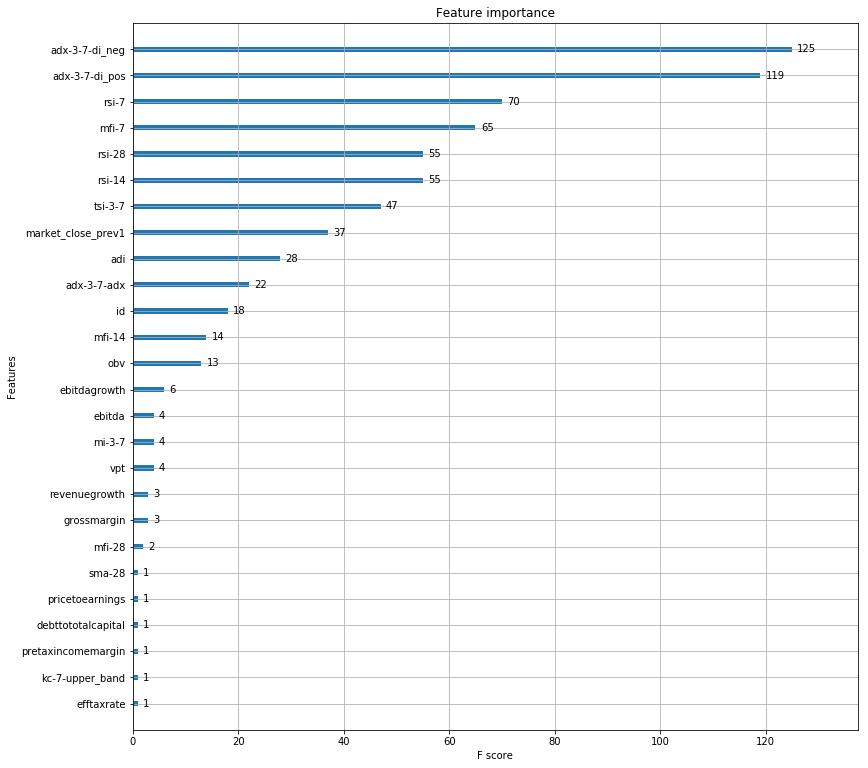

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(13,13))
plot_importance(booster=model_class, ax=ax)

In [ ]:
def fitness_class(params):
    params['seed'] = 42
    params['n_jobs'] = 4
    model_class = XGBClassifier(**params)  

    model_class.fit(
        X_train, 
        Y_train_classify, 
        eval_set=[(X_train, Y_train_classify), (X_valid, Y_valid_classify)],   
        verbose=False,
        eval_metric='auc',
        early_stopping_rounds = 10)
    return -model_class.best_score

patterns = [
    ("max_depth", int, 1, 50),
    ("n_estimators", int, 10, 10000),
    ("min_child_weight", int, 10, 5000),
    ("colsample_bytree", float, 0.0, 1.0),
    ("subsample", float, 0.1, 1.0),
    ("eta", float, 0.0, 1.0),
]

In [ ]:
random.seed(42)
ts = time.time()
opt_class, fitness_class_res = pso.optimize(patterns, fitness_class)
time.time() - ts

n_estimators.dim_velocity = 0.0
*[1]particle.values={'max_depth': 41, 'n_estimators': 1834, 'min_child_weight': 214, 'colsample_bytree': 0.7415504997598329, 'subsample': 0.3204026684231286, 'eta': 0.1395379285251439}
n_estimators.dim_velocity = -2505.1051636621605
*[1]particle.values={'max_depth': 21, 'n_estimators': 6439, 'min_child_weight': 664, 'colsample_bytree': 0.5965191201678559, 'subsample': 0.1382903605856734, 'eta': 0.10826598189493027}
n_estimators.dim_velocity = -861.6709206635134
*[1]particle.values={'max_depth': 19, 'n_estimators': 7427, 'min_child_weight': 3409, 'colsample_bytree': 0.0877192797434631, 'subsample': 0.2823403028548622, 'eta': 0.39738454386798144}
n_estimators.dim_velocity = -2127.7796725191743
*[1]particle.values={'max_depth': 36, 'n_estimators': 4755, 'min_child_weight': 1631, 'colsample_bytree': 0.4953190475703636, 'subsample': 0.34721016825974976, 'eta': 0.5495302529925641}
n_estimators.dim_velocity = -361.70357174238495
*[1]particle.values={'max_depth'

n_estimators.dim_velocity = -41.52379463466403
*[8]particle.values={'max_depth': 40, 'n_estimators': 1611, 'min_child_weight': 228, 'colsample_bytree': 0.7387015498627189, 'subsample': 0.3286210100337945, 'eta': 0.13897031147949515}
n_estimators.dim_velocity = 203.12054767683833
*[8]particle.values={'max_depth': 40, 'n_estimators': 2561, 'min_child_weight': 169, 'colsample_bytree': 0.6266370922595291, 'subsample': 0.3167615554317964, 'eta': 0.13409734207606178}
n_estimators.dim_velocity = -317.40085258072787
*[8]particle.values={'max_depth': 40, 'n_estimators': 2130, 'min_child_weight': 297, 'colsample_bytree': 0.7433831367484206, 'subsample': 0.32213526641090884, 'eta': 0.13473956241352955}
n_estimators.dim_velocity = -49.2983985476128
*[8]particle.values={'max_depth': 41, 'n_estimators': 1926, 'min_child_weight': 211, 'colsample_bytree': 0.7343885024475394, 'subsample': 0.3169865751072639, 'eta': 0.16575118968888472}
n_estimators.dim_velocity = 0.0
*[9]particle.values={'max_depth': 4

In [ ]:
opt_class, fitness_class_res

In [ ]:
# params_pso_class = {'colsample_bytree': 0.6160255388578953,
#   'eta': 0.2695933770248609,
#   'max_depth': 13,
#   'min_child_weight': 229,
#   'n_estimators': 4946,
#   'subsample': 0.8236539165798413,
#   'seed': 42}
model_pso_class_opt = XGBClassifier(**opt_class)
model_pso_class_opt.fit(
        X_train, 
        Y_train_regr, 
        eval_set=[(X_train, Y_train_class), (X_valid, Y_valid_class)],   
        verbose=False,
        eval_metric='mae',
        early_stopping_rounds = 10)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
plot_importance(booster=model_pso_class_opt, ax=ax, max_num_features=20, title='Feature importance (regression)')

In [ ]:
random.seed(42)
param_dist = {"max_depth": sp.stats.randint(1, 50),
              "n_estimators": sp.stats.randint(10, 10000),
              "min_child_weight": sp.stats.randint(10, 10000),
              "subsample": sp.stats.uniform(0, 1),
              "colsample_bytree": sp.stats.uniform(0, 1),
              "eta":sp.stats.uniform(0, 1)}
search_classif=RandomizedSearchCV(XGBClassifier(), param_distributions=param_dist, scoring="roc_auc", n_jobs=3, verbose=10)
search_classif.fit(X_train, Y_train_classify)

In [ ]:
search_classif.best_estimator_

In [ ]:
search_classif.best_score_

In [ ]:
ts = time.time()
model_class = XGBClassifier()
model_class.set_params(**search_classif.best_estimator_.get_params())

model_class.fit(
        X_train, 
        Y_train_classify, 
        eval_set=[(X_train, Y_train_classify), (X_valid, Y_valid_classify)], 
        verbose=True,         
        eval_metric='auc',
        early_stopping_rounds = 10)
    
time.time() - ts